In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import cartopy
import cmaps
import proplot as pplt
import cnmaps
from scipy.stats import linregress
from minisom import MiniSom
from scipy.spatial import distance
import proplot as pplt
import random

import os
os.chdir('/Users/zeqinhuang/Documents/paper/anomalous_PREC')

import warnings
warnings.filterwarnings('ignore')

In [202]:
def determine_winner(prec_ano_data,n,m):

    data_stack = prec_ano_data.stack(z=('lon','lat'))
    data_stack_del_nan = data_stack.loc[:,data_stack['z'][~np.isnan(data_stack[0,:])]] ##### delete nan values
    data_stack = data_stack_del_nan.values
    data_stack = pd.DataFrame(data_stack)
    data_stack = data_stack.to_numpy()
 
    som = MiniSom(n, m, data_stack.shape[1], sigma=1, learning_rate=.5,
                  neighborhood_function='gaussian', random_seed=1)
    som.train(data_stack, 80000) 
    winners = []
   
    if n == 2 and m == 3:
        for i in range(len(data_stack)):
            dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
            dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
            dist3 = distance.euclidean(data_stack[i],som.get_weights()[0,2,:])
            dist4 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
            dist5 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
            dist6 = distance.euclidean(data_stack[i],som.get_weights()[1,2,:])
            dists = np.array([dist1,dist2,dist3,dist4,dist5,dist6])
            winner = dists.argmin()
            winners.append(winner)
    elif n == 2 and m == 2:
        for i in range(len(data_stack)):
            dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
            dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
            dist3 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
            dist4 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
            dists = np.array([dist1,dist2,dist3,dist4])
            winner = dists.argmin()
            winners.append(winner)
    elif n == 2 and m == 4:
        for i in range(len(data_stack)):
            dist1 = distance.euclidean(data_stack[i],som.get_weights()[0,0,:])
            dist2 = distance.euclidean(data_stack[i],som.get_weights()[0,1,:])
            dist3 = distance.euclidean(data_stack[i],som.get_weights()[0,2,:])
            dist4 = distance.euclidean(data_stack[i],som.get_weights()[0,3,:])
            dist5 = distance.euclidean(data_stack[i],som.get_weights()[1,0,:])
            dist6 = distance.euclidean(data_stack[i],som.get_weights()[1,1,:])
            dist7 = distance.euclidean(data_stack[i],som.get_weights()[1,2,:])
            dist8 = distance.euclidean(data_stack[i],som.get_weights()[1,3,:])
            dists = np.array([dist1,dist2,dist3,dist4,dist5,dist6,dist7,dist8])
            winner = dists.argmin()
            winners.append(winner)

    return winners

In [2]:
prec_ano = xr.open_dataarray('dataset/china_daily_precipitation_summer_anomalies_1961_2018.nc')
ano_date = pd.read_csv('output/ano_dates_95th.csv',index_col=0,header=0)
ano_date = pd.to_datetime(ano_date.index,format='%Y-%m-%d')
prec_ano_95th = prec_ano.sel(time = ano_date)

In [5]:
winner = determine_winner(prec_ano_95th,2,3)
winner = np.array(winner)
winner = pd.Series(winner,index=ano_date)

In [139]:
def monte_carlo_sampling(prec_ano_grid,winner_type):
    total_sample = len(prec_ano_grid)
    if (np.isnan(prec_ano_grid).sum() == total_sample):
        sig = False
    else:
        winner_number = sum(winner == winner_type)
        winner_freq = sum((prec_ano_grid>0) * (winner == winner_type))
        if winner_number == 0:
            sig = False
            pass
        else:
            k_winner_freqs = []
            for i in range(1000):
                random.seed(i*i + 1000*i)
                index_sample = random.sample(ano_date.tolist(), winner_number)
                k_sample_winner = winner[index_sample]
                prec_ano_grid = pd.Series(prec_ano_grid, index=ano_date)
                k_sample_prec = prec_ano_grid[index_sample]
                k_winner_freq = sum((k_sample_prec>0))
                k_winner_freqs.append(k_winner_freq)
            f095 = np.quantile(k_winner_freqs, 0.95)
            if winner_freq > f095:
                sig = True
            else:
                sig = False
    return sig

def monte_carlo_test(prec_ano_95th,i):
    monte_carlo_sig = xr.apply_ufunc(
        monte_carlo_sampling,
        prec_ano_95th,
        vectorize=True,
        dask='parallelized', 
        input_core_dims=[['time']],
        output_core_dims=[[]],
        kwargs={'winner_type':i}
        )
    return monte_carlo_sig

In [140]:
sig_NC = monte_carlo_test(prec_ano_95th,0)
sig_SW = monte_carlo_test(prec_ano_95th,1)
sig_YRB = monte_carlo_test(prec_ano_95th,2)
sig_EC = monte_carlo_test(prec_ano_95th,3)
sig_HRB = monte_carlo_test(prec_ano_95th,4)
sig_SC = monte_carlo_test(prec_ano_95th,5)

In [141]:
sig_NC.to_netcdf('dataset/monte_carlo_sig_NC.nc')
sig_SW.to_netcdf('dataset/monte_carlo_sig_SW.nc')
sig_YRB.to_netcdf('dataset/monte_carlo_sig_YRB.nc')
sig_EC.to_netcdf('dataset/monte_carlo_sig_EC.nc')
sig_HRB.to_netcdf('dataset/monte_carlo_sig_HRB.nc')
sig_SC.to_netcdf('dataset/monte_carlo_sig_SC.nc')

In [206]:
# winner for grid(2,2)
winner = determine_winner(prec_ano_95th,2,2)
winner = np.array(winner)
winner = pd.Series(winner,index=ano_date)

sig_2x2_1 = monte_carlo_test(prec_ano_95th,0)
sig_2x2_2 = monte_carlo_test(prec_ano_95th,1)
sig_2x2_3 = monte_carlo_test(prec_ano_95th,2)
sig_2x2_4 = monte_carlo_test(prec_ano_95th,3)

sig_2x2_1.to_netcdf('dataset/monte_carlo_2x2_1.nc')
sig_2x2_2.to_netcdf('dataset/monte_carlo_2x2_2.nc')
sig_2x2_3.to_netcdf('dataset/monte_carlo_2x2_3.nc')
sig_2x2_4.to_netcdf('dataset/monte_carlo_2x2_4.nc')

In [207]:
# winner for grid(2,4)
winner = determine_winner(prec_ano_95th,2,4)
winner = np.array(winner)
winner = pd.Series(winner,index=ano_date)

sig_2x4_1 = monte_carlo_test(prec_ano_95th,0)
sig_2x4_2 = monte_carlo_test(prec_ano_95th,1)
sig_2x4_3 = monte_carlo_test(prec_ano_95th,2)
sig_2x4_4 = monte_carlo_test(prec_ano_95th,3)
sig_2x4_5 = monte_carlo_test(prec_ano_95th,4)
sig_2x4_6 = monte_carlo_test(prec_ano_95th,5)
sig_2x4_7 = monte_carlo_test(prec_ano_95th,6)
sig_2x4_8 = monte_carlo_test(prec_ano_95th,7)

sig_2x4_1.to_netcdf('dataset/monte_carlo_2x4_1.nc')
sig_2x4_2.to_netcdf('dataset/monte_carlo_2x4_2.nc')
sig_2x4_3.to_netcdf('dataset/monte_carlo_2x4_3.nc')
sig_2x4_4.to_netcdf('dataset/monte_carlo_2x4_4.nc')
sig_2x4_5.to_netcdf('dataset/monte_carlo_2x4_5.nc')
sig_2x4_6.to_netcdf('dataset/monte_carlo_2x4_6.nc')
sig_2x4_7.to_netcdf('dataset/monte_carlo_2x4_7.nc')
sig_2x4_8.to_netcdf('dataset/monte_carlo_2x4_8.nc')

## SOM pattern statistics

In [144]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_map, draw_map, clip_contours_by_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

# data for drawing South China sea
with open('dataset/CN_border_shapefile/CN-border-L1.dat') as src:
    context = src.read()
    blocks = [cnt for cnt in context.split('>') if len(cnt) > 0]
    borders = [np.fromstring(block, dtype=float, sep=' ') for block in blocks]

river = shpreader.Reader('dataset/River_shapefile/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=0.7)

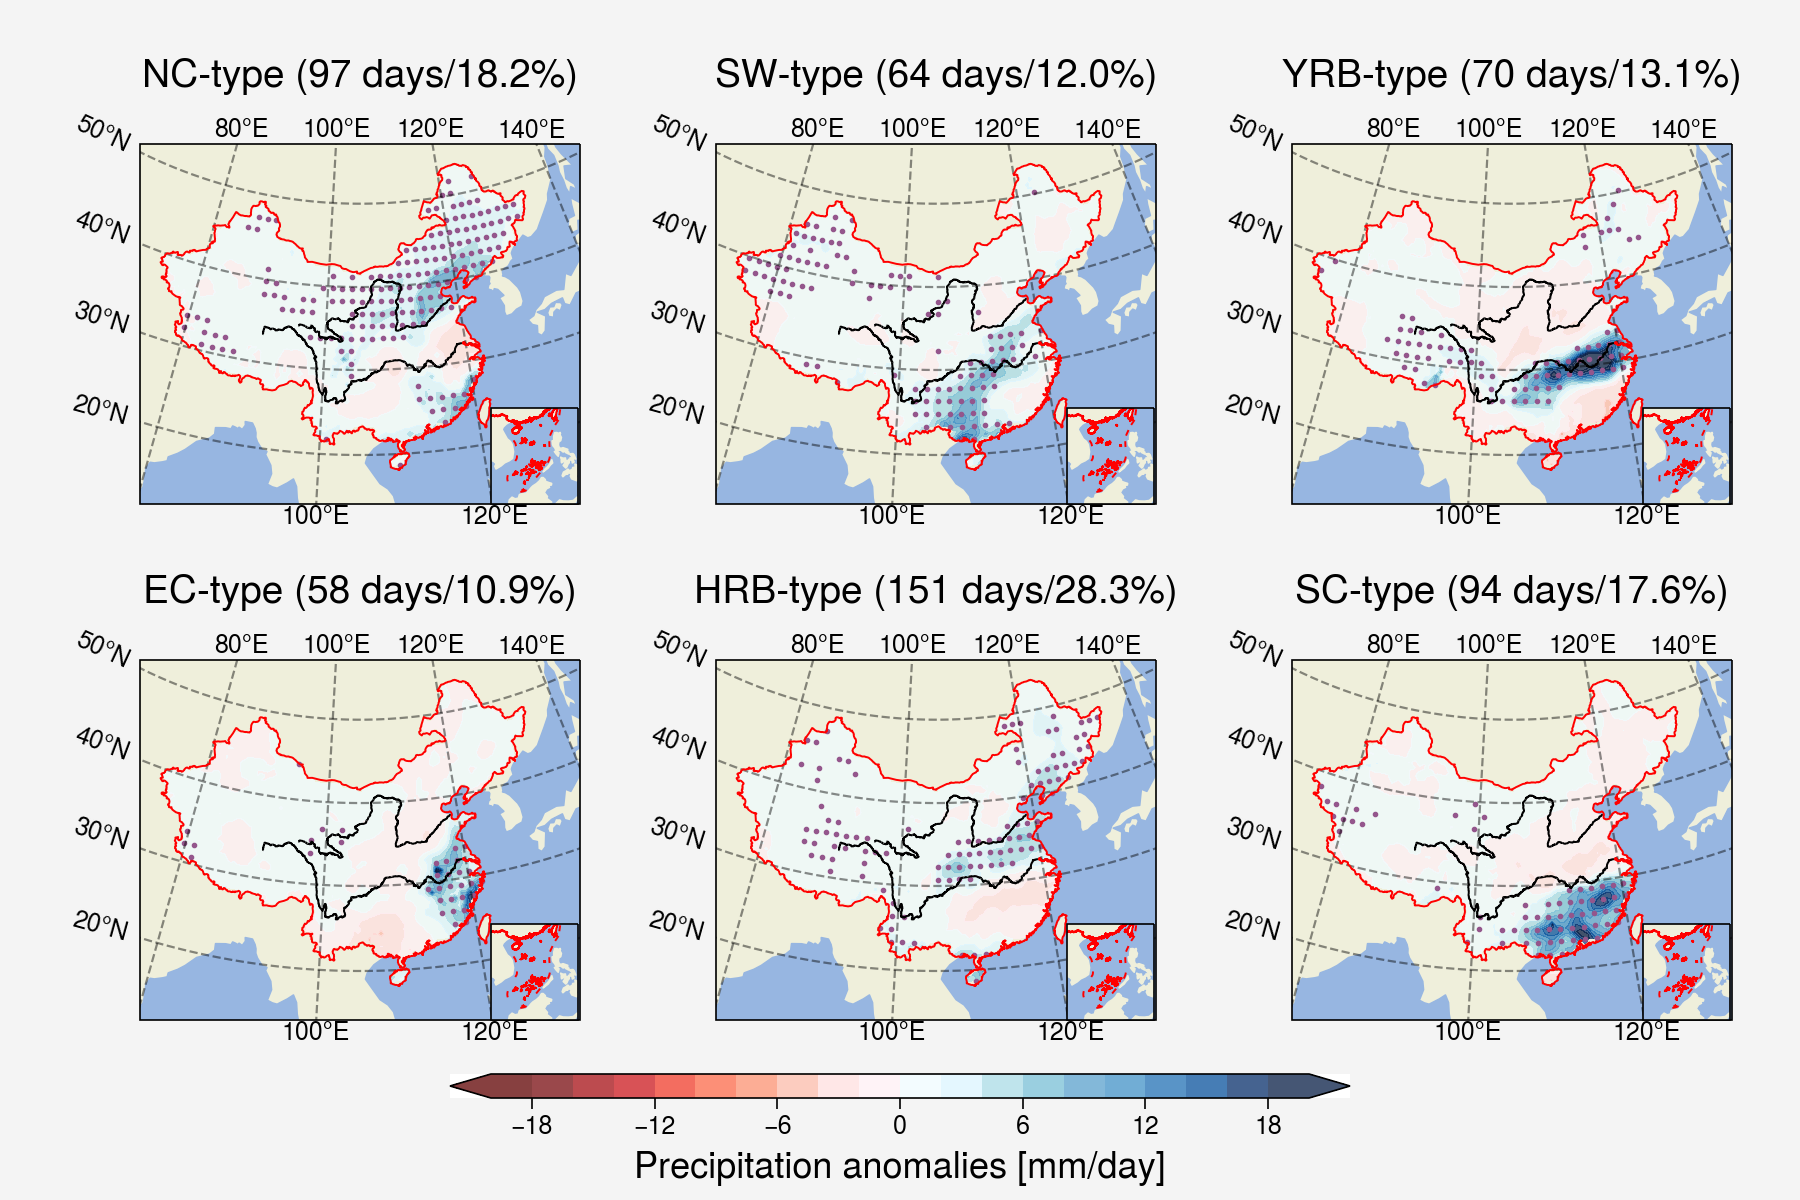

In [197]:
mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-20 + 2 * i for i in range(21)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.3,0.3],
    [0.37,0.58,0.3,0.3],
    [0.69,0.58,0.3,0.3],
    [0.05,0.15,0.3,0.3],
    [0.37,0.15,0.3,0.3],
    [0.69,0.15,0.3,0.3],
]
subaxes_locs = [
    [0.22 + 0.027, 0.58, 0.1, 0.08],
    [0.55 + 0.017, 0.58, 0.1, 0.08],
    [0.88 + 0.007, 0.58, 0.1, 0.08],
    [0.22 + 0.027, 0.15, 0.1, 0.08],
    [0.55 + 0.017, 0.15, 0.1, 0.08],
    [0.88 + 0.007, 0.15, 0.1, 0.08]
]
types = ['NC-type','SW-type','YRB-type','EC-type','HRB-type','SC-type']
mc_sig = ['NC','SW','YRB','EC','HRB','SC']

fig = plt.figure(figsize = (9,6))
for i in range(6):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner.to_numpy()==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    sig = xr.open_dataarray('dataset/monte_carlo_sig_' + mc_sig[i] + '.nc').values
    X,Y = np.meshgrid(lon[::3],lat[::3])
    sig = sig[::3,::3]
    X = X[sig]
    Y = Y[sig]
    ax1.scatter(X,Y,s=2,c='purple',alpha=1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    sub_ax = fig.add_axes(subaxes_locs[i], projection=ccrs.LambertConformal(central_latitude=90,central_longitude=115))#
    sub_ax.add_feature(cfeature.OCEAN.with_scale('110m'))
    sub_ax.add_feature(cfeature.LAND.with_scale('110m'))
    for line in borders:
        sub_ax.plot(line[0::2], line[1::2], '-', color='r',transform=ccrs.Geodetic(),linewidth=0.7)
    sub_ax.set_extent([105, 125, 0, 25])

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_95th_monte_carlo.pdf")

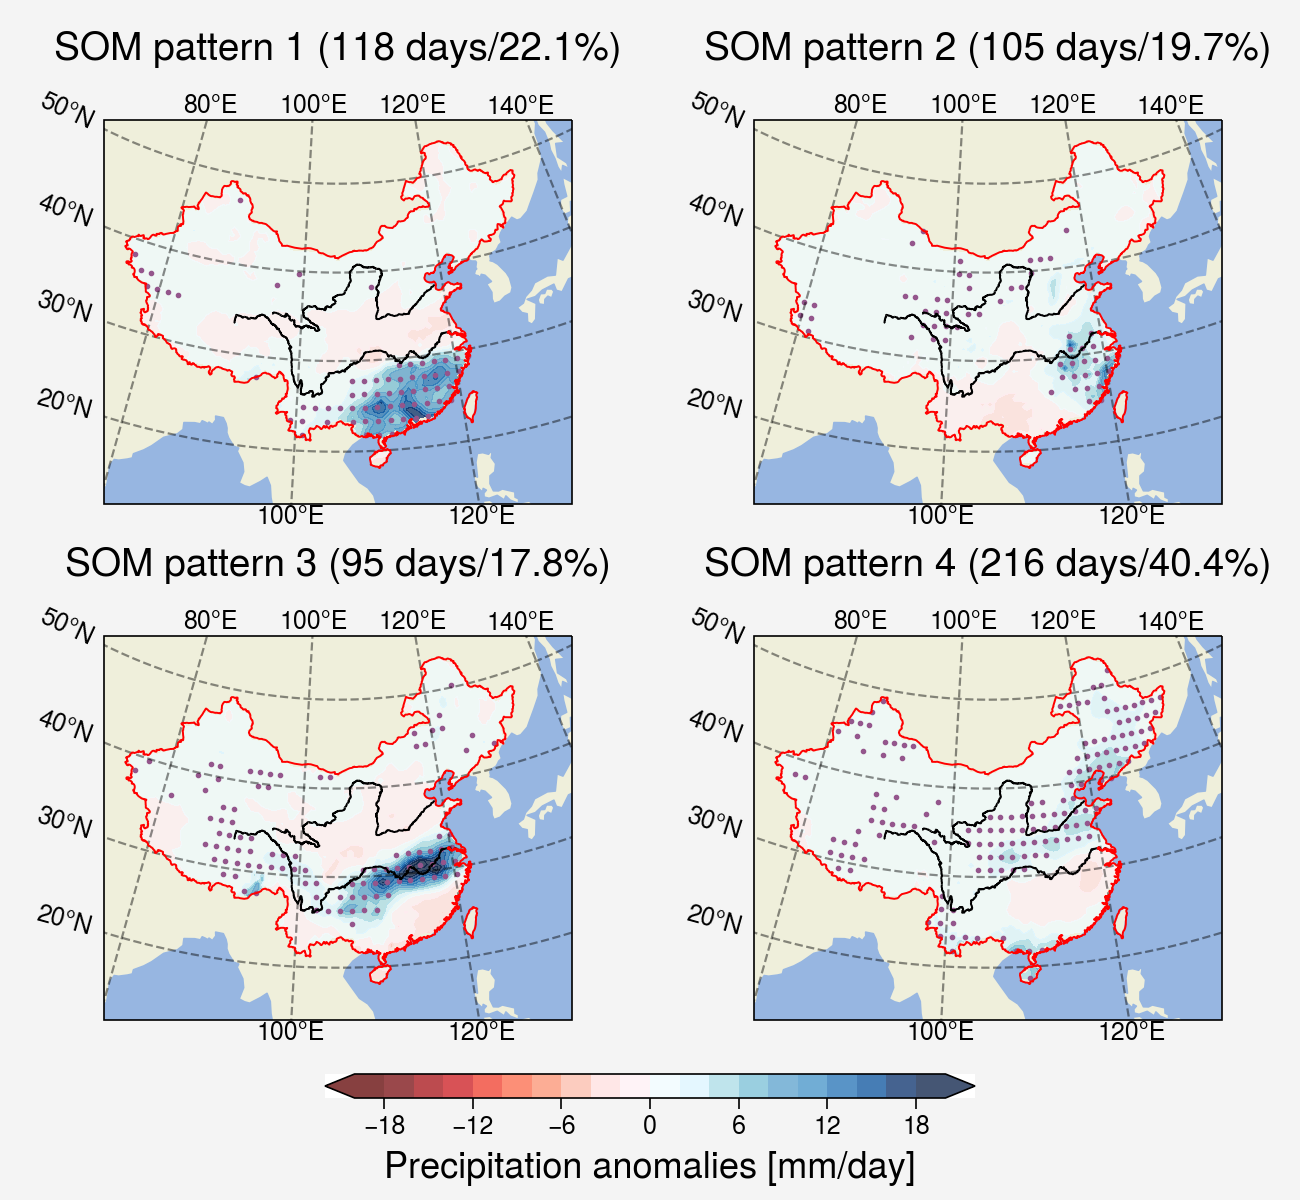

In [215]:
winner = determine_winner(prec_ano_95th,2,2)
winner = np.array(winner)
winner = pd.Series(winner,index=ano_date)

mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-20 + 2 * i for i in range(21)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.42,0.32],
    [0.55,0.58,0.42,0.32],
    [0.05,0.15,0.42,0.32],
    [0.55,0.15,0.42,0.32],
]

types = ['SOM pattern 1','SOM pattern 2','SOM pattern 3','SOM pattern 4']
mc_sig = ['2x2_1','2x2_2','2x2_3','2x2_4']

fig = plt.figure(figsize = (6.5,6))
for i in range(4):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner.to_numpy()==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    sig = xr.open_dataarray('dataset/monte_carlo_' + mc_sig[i] + '.nc').values
    X,Y = np.meshgrid(lon[::3],lat[::3])
    sig = sig[::3,::3]
    X = X[sig]
    Y = Y[sig]
    ax1.scatter(X,Y,s=2,c='purple',alpha=1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_95th_monte_carlo_2x2.pdf")

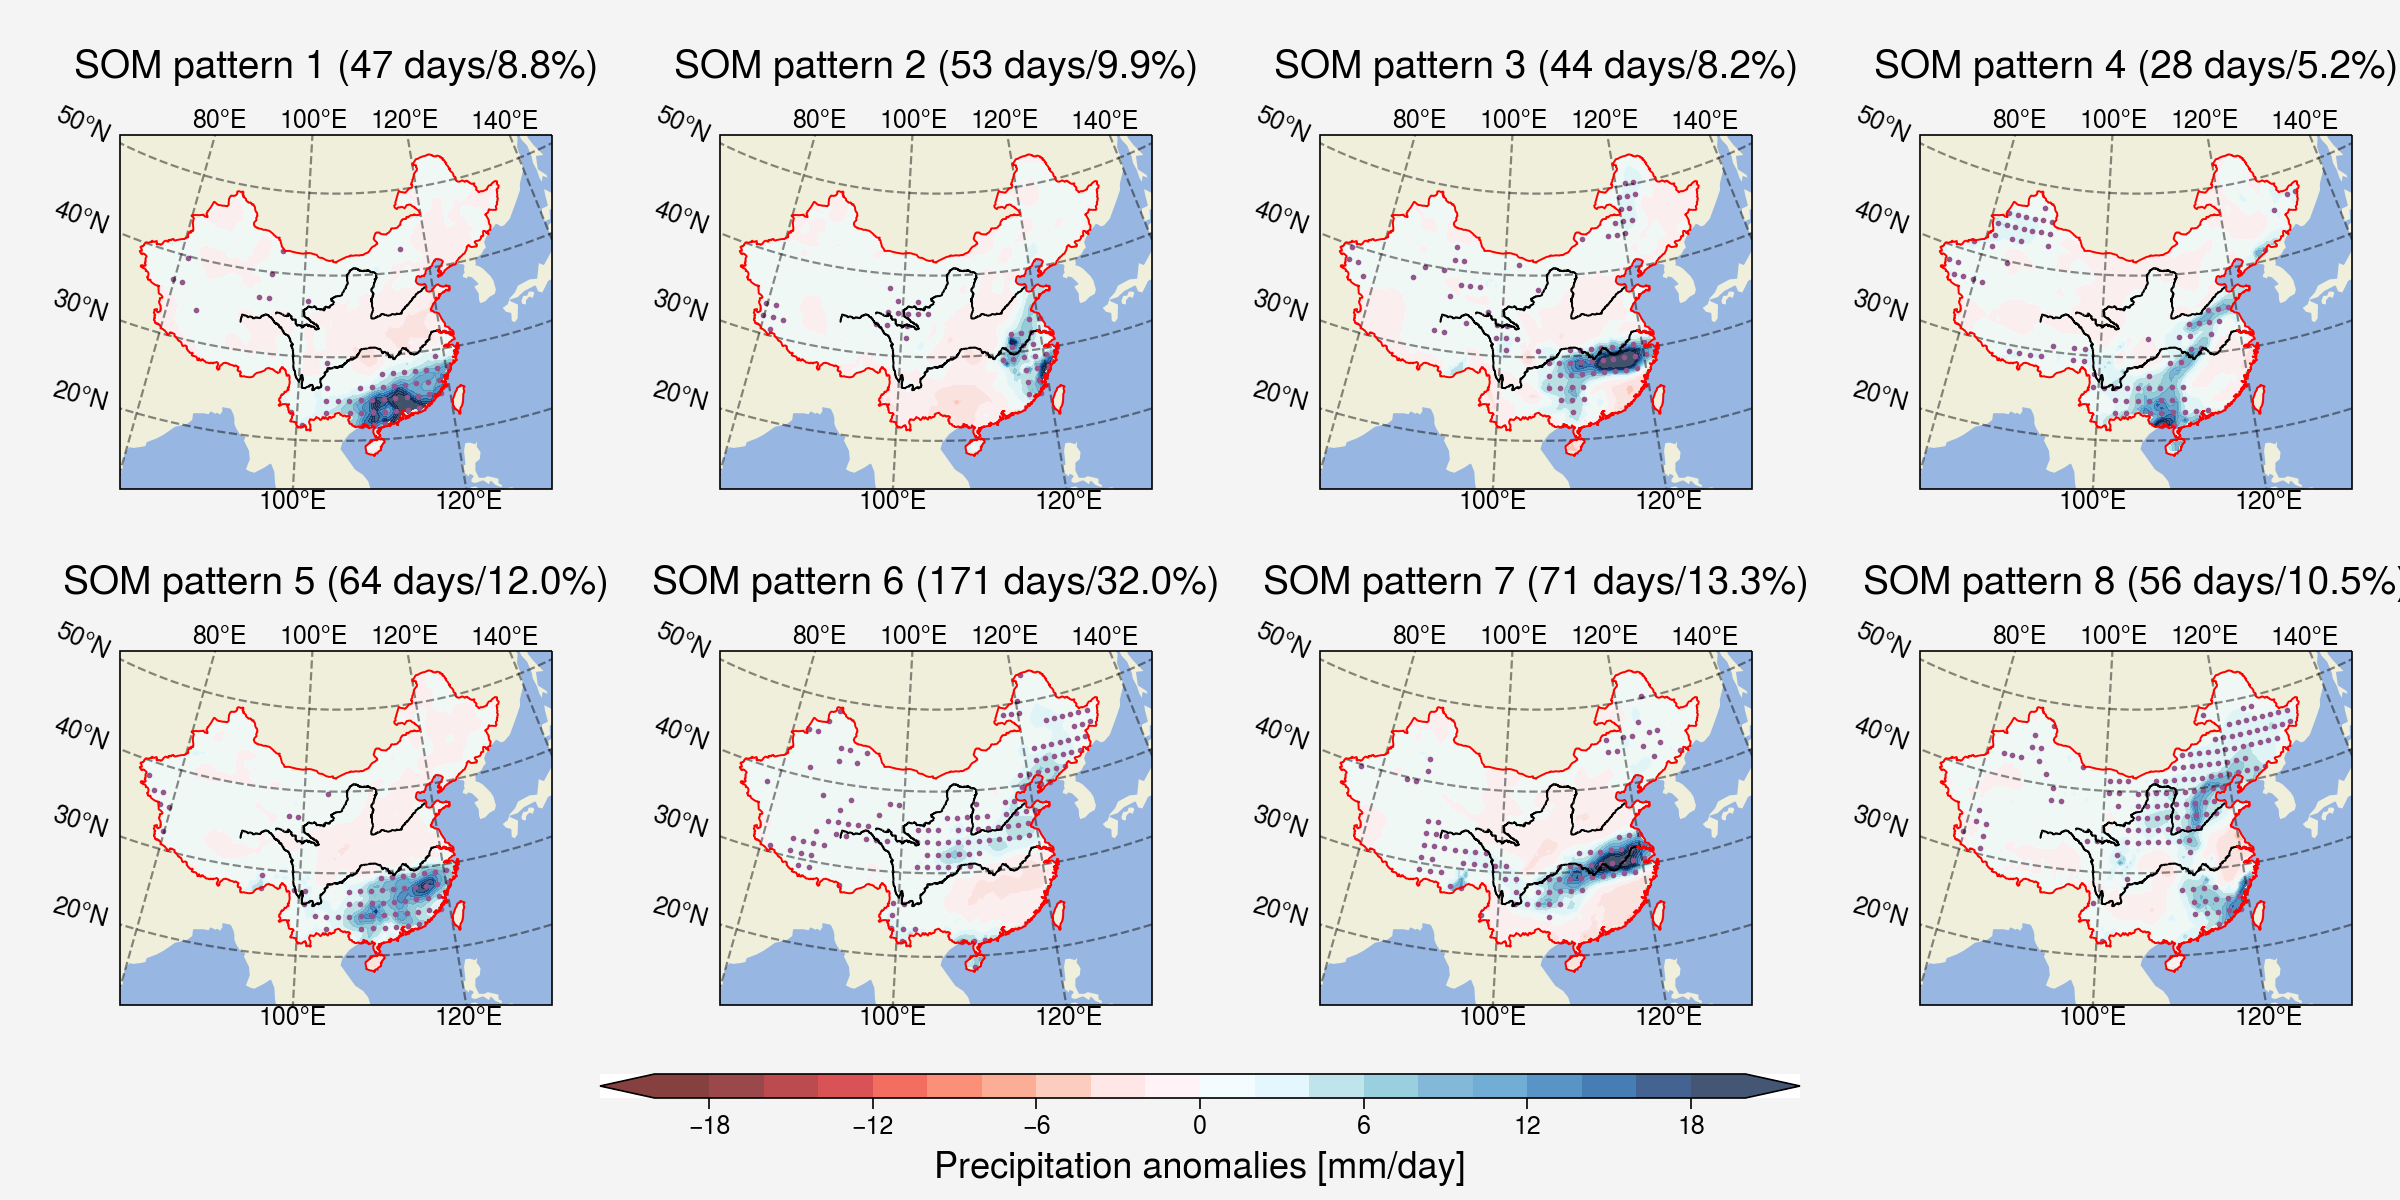

In [218]:
winner = determine_winner(prec_ano_95th,2,4)
winner = np.array(winner)
winner = pd.Series(winner,index=ano_date)

mapcrs = ccrs.LambertConformal(central_latitude=90,central_longitude=105)
levels = [-20 + 2 * i for i in range(21)]
# cmap1 = cmaps.temp_diff_18lev_r
cmap1 = cmaps.temp_19lev_r

axes_locs = [
    [0.05,0.58,0.18,0.32],
    [0.30,0.58,0.18,0.32],
    [0.55,0.58,0.18,0.32],
    [0.80,0.58,0.18,0.32],

    [0.05,0.15,0.18,0.32],
    [0.30,0.15,0.18,0.32],
    [0.55,0.15,0.18,0.32],
    [0.80,0.15,0.18,0.32],
]

types = ['SOM pattern 1','SOM pattern 2','SOM pattern 3','SOM pattern 4','SOM pattern 5','SOM pattern 6','SOM pattern 7','SOM pattern 8']
mc_sig = ['2x4_1','2x4_2','2x4_3','2x4_4','2x4_5','2x4_6','2x4_7','2x4_8']

fig = plt.figure(figsize = (12,6))
for i in range(8):
    ax1 = fig.add_axes(axes_locs[i], projection = mapcrs)
    prec_ano_95th_winner_i = prec_ano_95th.loc[winner.to_numpy()==i,:,:]
    prec_ano_95th_winner_i = prec_ano_95th_winner_i.mean(axis=0)
    lon = prec_ano_95th_winner_i['lon']
    lat = prec_ano_95th_winner_i['lat']
    p1 = ax1.contourf(lon,lat,prec_ano_95th_winner_i,levels = levels, alpha=0.75, extend = 'both',cmap=cmap1, transform = ccrs.PlateCarree())

    sig = xr.open_dataarray('dataset/monte_carlo_' + mc_sig[i] + '.nc').values
    X,Y = np.meshgrid(lon[::3],lat[::3])
    sig = sig[::3,::3]
    X = X[sig]
    Y = Y[sig]
    ax1.scatter(X,Y,s=2,c='purple',alpha=1, transform = ccrs.PlateCarree())

    ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
    ax1.add_feature(river_feature)
    ax1.set_extent([80, 130, 13, 55]) #.set_extent([72, 136, 18, 50])
    # ax1.set_title('SOM Pattern '+str(i + 1)+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':12,'fontweight': 'medium'},y=1.12)
    ax1.set_title(types[i]+' ('+str(sum(winner==i))+' days/'+'{:.1%}'.format(sum(winner==i)/len(winner))+')',fontdict={'fontsize':14,'fontweight': 'medium'},y=1.12)

    china = get_map('中国')
    draw_map(china,color='r',linewidth=0.7)

    gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.45, linestyle='--', draw_labels=True)
    gl1.xlabel_style = {'rotation': 0, 'ha':'center'}
    gl1.right_labels = False

# set colorbar
cbar_ax = fig.add_axes([0.25, 0.085, 0.5, 0.02])
fig_cbar = fig.colorbar(p1, cax=cbar_ax, orientation ='horizontal')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Precipitation anomalies [mm/day]',fontdict={'fontsize': 13, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

fig_dir = 'figure/'
fig.savefig(fig_dir + "anomalous_precipitation_cluster_95th_monte_carlo_2x4.pdf")